# Criação de um mapa coroplético para candidatos

## Importação de bibliotecas, base de dados eleitorais e mapas

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
df_mun_BR_18 = pd.read_csv('Dados_Eleitorais/Nacional/votacao_candidato_munzona_2018_BRASIL.csv', encoding='latin1', sep=';')
df_mun_SP_20 = pd.read_csv('Dados_Eleitorais/São Paulo/2020 - Muncipais/votacao_secao_2020_SP.csv', encoding='latin1', sep=';')
df_mun_SP_22 = pd.read_csv('Dados_Eleitorais/São Paulo/2022 - Presidencial, Governador, Deputados e Senador/votacao_secao_2022_SP.csv', encoding='latin1', sep=';')
SP_2020_Zonas = gpd.read_file('Mapas/São Paulo/Mapa_Zonas_Eleitorais_SP/ZONAS_FINAL.shp')

É importante ressaltar que nosso trabalho envolverá o uso de bancos de dados que abrangem diferentes tipos de eleições. Nas eleições de 2018 e 2022, lidaremos com os pleitos majoritários, que incluem as disputas presidenciais, para senadores e governadores, além das proporcionais para deputados federais e estaduais. Já na eleição de 2020, focalizaremos nos cargos municipais, como prefeitos e vereadores

Para ilustrar, iremos criar mapas com referência ao candidato Guilherme Boulos como exemplo. Considerando sua participação em distintos processos eleitorais ao longo desses três anos, será possível observar possíveis variações em seu eleitorado ao longo do tempo, bem como diferenças entre os tipos de eleição.

## Criação do Mapa das Eleições de 2018

In [4]:
df_mun_BR_18.columns

Index(['DT_GERACAO', 'HH_GERACAO', 'ANO_ELEICAO', 'CD_TIPO_ELEICAO',
       'NM_TIPO_ELEICAO', 'NR_TURNO', 'CD_ELEICAO', 'DS_ELEICAO', 'DT_ELEICAO',
       'TP_ABRANGENCIA', 'SG_UF', 'SG_UE', 'NM_UE', 'CD_MUNICIPIO',
       'NM_MUNICIPIO', 'NR_ZONA', 'CD_CARGO', 'DS_CARGO', 'SQ_CANDIDATO',
       'NR_CANDIDATO', 'NM_CANDIDATO', 'NM_URNA_CANDIDATO',
       'NM_SOCIAL_CANDIDATO', 'CD_SITUACAO_CANDIDATURA',
       'DS_SITUACAO_CANDIDATURA', 'CD_DETALHE_SITUACAO_CAND',
       'DS_DETALHE_SITUACAO_CAND', 'TP_AGREMIACAO', 'NR_PARTIDO', 'SG_PARTIDO',
       'NM_PARTIDO', 'NR_FEDERACAO', 'NM_FEDERACAO', 'SG_FEDERACAO',
       'DS_COMPOSICAO_FEDERACAO', 'SQ_COLIGACAO', 'NM_COLIGACAO',
       'DS_COMPOSICAO_COLIGACAO', 'ST_VOTO_EM_TRANSITO', 'QT_VOTOS_NOMINAIS',
       'NM_TIPO_DESTINACAO_VOTOS', 'QT_VOTOS_NOMINAIS_VALIDOS',
       'CD_SIT_TOT_TURNO', 'DS_SIT_TOT_TURNO'],
      dtype='object')

In [5]:
df_mun_BR_18['QT_VOTOS_NOMINAIS_VALIDOS'] =df_mun_BR_18['QT_VOTOS_NOMINAIS_VALIDOS'].astype(int)


In [6]:
df_mun_BR_18 = df_mun_BR_18[(df_mun_BR_18['DS_CARGO'] == 'Presidente') & 
                            (df_mun_BR_18['NR_TURNO'] == 1) & 
                            (df_mun_BR_18['SG_UF'] == 'SP') & 
                            (df_mun_BR_18['NM_MUNICIPIO'] == 'SÃO PAULO') & 
                            (df_mun_BR_18['NR_CANDIDATO'] == 50)]


In [7]:
pivot_df_2018_SP_Boulos = df_mun_BR_18.pivot_table(
    index='NR_ZONA',
    values='QT_VOTOS_NOMINAIS_VALIDOS',
    aggfunc='sum',  # Usando a string 'sum' para evitar o FutureWarning
    fill_value=0
).reset_index()

In [8]:
pivot_df_2018_SP_Boulos = pivot_df_2018_SP_Boulos.astype('int64')

In [9]:
SP_2020_Zonas.rename(columns={'ZEFINAL': 'NR_ZONA'}, inplace=True)


In [10]:
mapa_saopaulo_18_Boulos = SP_2020_Zonas.merge(pivot_df_2018_SP_Boulos, on='NR_ZONA')

C:\Users\Redes\AppData\Local\Temp\ipykernel_17732\1732088004.py:25: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  mapa_saopaulo_18_Boulos.to_file('Mapas/São Paulo/2018/Mapa_Boulos_2018/Shapefile/mapa_saopaulo_18_Boulos.shp')


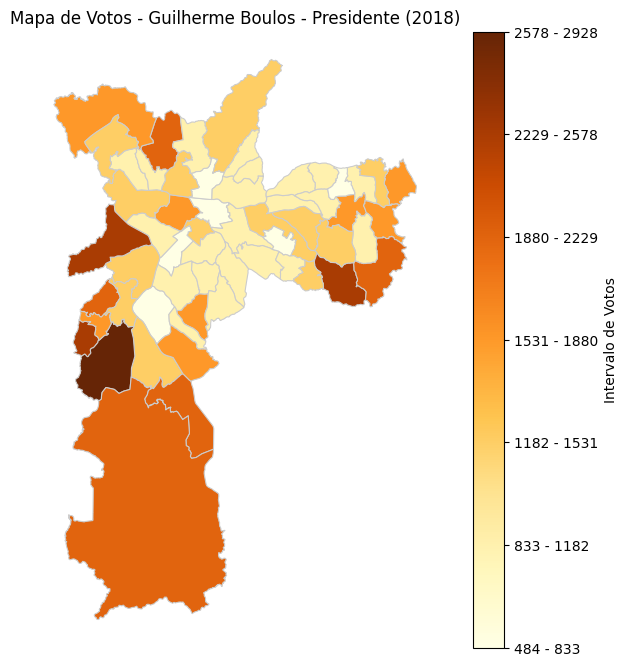

In [11]:
num_categorias = 7

intervalos_proporcionais = np.linspace(mapa_saopaulo_18_Boulos['QT_VOTOS_NOMINAIS_VALIDOS'].min(), mapa_saopaulo_18_Boulos['QT_VOTOS_NOMINAIS_VALIDOS'].max(), num_categorias + 1)

mapa_saopaulo_18_Boulos['categorias'] = pd.cut(mapa_saopaulo_18_Boulos['QT_VOTOS_NOMINAIS_VALIDOS'], bins=intervalos_proporcionais, labels=False, include_lowest=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

cmap = plt.cm.YlOrBr

mapa_saopaulo_18_Boulos.plot(column="categorias", cmap=cmap, linewidth=0.8, ax=ax, edgecolor="0.8", legend=False, vmin=0)

ax.set_title("Mapa de Votos - Guilherme Boulos - Presidente (2018)")
ax.set_axis_off()

etiquetas_legenda = [f'{int(intervalos_proporcionais[i])} - {int(intervalos_proporcionais[i+1])}' for i in range(len(intervalos_proporcionais)-1)]

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=num_categorias-1))
sm._A = []  
cbar = fig.colorbar(sm, ticks=np.arange(num_categorias), ax=ax)
cbar.set_label('Intervalo de Votos')
cbar.set_ticklabels(etiquetas_legenda)


mapa_saopaulo_18_Boulos.to_file('Mapas/São Paulo/2018/Mapa_Boulos_2018/Shapefile/mapa_saopaulo_18_Boulos.shp')


gdf_mapa = gpd.GeoDataFrame(mapa_saopaulo_18_Boulos)



caminho_geojson = "Mapas/São Paulo/2018/Mapa_Boulos_2018/Geojson/mapa_votos_guilherme_boulos_2020.geojson"


gdf_mapa.to_file(caminho_geojson, driver='GeoJSON')

plt.show()


In [12]:
pivot_df_2018_SP_Boulos.to_csv('Mapas/São Paulo/2018/pivot_df_2018_SP_Boulos.csv', index=False)

## Criação do Mapa do 1º Turno das Eleições de 2020

In [13]:
df_mun_SP_20.columns

Index(['DT_GERACAO', 'HH_GERACAO', 'ANO_ELEICAO', 'CD_TIPO_ELEICAO',
       'NM_TIPO_ELEICAO', 'NR_TURNO', 'CD_ELEICAO', 'DS_ELEICAO', 'DT_ELEICAO',
       'TP_ABRANGENCIA', 'SG_UF', 'SG_UE', 'NM_UE', 'CD_MUNICIPIO',
       'NM_MUNICIPIO', 'NR_ZONA', 'NR_SECAO', 'CD_CARGO', 'DS_CARGO',
       'NR_VOTAVEL', 'NM_VOTAVEL', 'QT_VOTOS', 'NR_LOCAL_VOTACAO',
       'SQ_CANDIDATO', 'NM_LOCAL_VOTACAO', 'DS_LOCAL_VOTACAO_ENDERECO'],
      dtype='object')

In [14]:
df_mun_SP_20_1 = df_mun_SP_20[(df_mun_SP_20['DS_CARGO'] == 'Prefeito') & 
                            (df_mun_SP_20['NR_TURNO'] == 1) & 
                            (df_mun_SP_20['SG_UF'] == 'SP') & 
                            (df_mun_SP_20['NM_MUNICIPIO'] == 'SÃO PAULO') & 
                            (df_mun_SP_20['NR_VOTAVEL'] == 50)]

In [15]:
df_mun_SP_20_1.head()

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,CD_TIPO_ELEICAO,NM_TIPO_ELEICAO,NR_TURNO,CD_ELEICAO,DS_ELEICAO,DT_ELEICAO,TP_ABRANGENCIA,...,NR_SECAO,CD_CARGO,DS_CARGO,NR_VOTAVEL,NM_VOTAVEL,QT_VOTOS,NR_LOCAL_VOTACAO,SQ_CANDIDATO,NM_LOCAL_VOTACAO,DS_LOCAL_VOTACAO_ENDERECO
67,21/12/2020,16:55:14,2020,2,Eleição Ordinária,1,426,Eleições Municipais 2020,15/11/2020,M,...,57,11,Prefeito,50,GUILHERME CASTRO BOULOS,33,1058,0,EE. SEN. PAULO EGYDIO DE O. CARVALHO,"RUA ARARITAGUABA, 1330"
80,21/12/2020,16:55:14,2020,2,Eleição Ordinária,1,426,Eleições Municipais 2020,15/11/2020,M,...,58,11,Prefeito,50,GUILHERME CASTRO BOULOS,30,1058,0,EE. SEN. PAULO EGYDIO DE O. CARVALHO,"RUA ARARITAGUABA, 1330"
1500,21/12/2020,16:55:14,2020,2,Eleição Ordinária,1,426,Eleições Municipais 2020,15/11/2020,M,...,165,11,Prefeito,50,GUILHERME CASTRO BOULOS,44,1210,0,EE. ALFREDO PAULINO,"RUA CAATIVA, 15"
1829,21/12/2020,16:55:14,2020,2,Eleição Ordinária,1,426,Eleições Municipais 2020,15/11/2020,M,...,11,11,Prefeito,50,GUILHERME CASTRO BOULOS,59,1015,0,EE. DEPUTADO RUBENS DO AMARAL,"RUA FILIPE CARDOSO, 554"
2873,21/12/2020,16:55:14,2020,2,Eleição Ordinária,1,426,Eleições Municipais 2020,15/11/2020,M,...,103,11,Prefeito,50,GUILHERME CASTRO BOULOS,62,1104,0,EE PROFESSORA MARIA AUGUSTA DE ÁVILA,"RUA FERNANDES PEREIRA, 690"


In [16]:
pivot_df_2020_SP_Boulos = df_mun_SP_20_1.pivot_table(
    index='NR_ZONA',
    values='QT_VOTOS',
    aggfunc='sum',  
    fill_value=0
).reset_index()

In [17]:
SP_2020_Zonas.rename(columns={'ZEFINAL': 'NR_ZONA'}, inplace=True)

In [18]:
mapa_saopaulo_20_Boulos = SP_2020_Zonas.merge(pivot_df_2020_SP_Boulos, on='NR_ZONA')

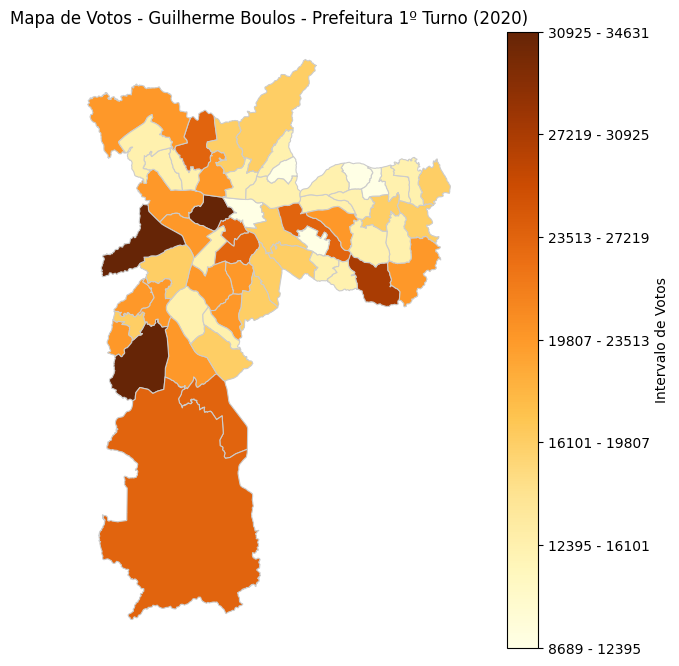

In [22]:
num_categorias = 7

intervalos_proporcionais = np.linspace(mapa_saopaulo_20_Boulos['QT_VOTOS'].min(), mapa_saopaulo_20_Boulos['QT_VOTOS'].max(), num_categorias + 1)

mapa_saopaulo_20_Boulos['categorias'] = pd.cut(mapa_saopaulo_20_Boulos['QT_VOTOS'], bins=intervalos_proporcionais, labels=False, include_lowest=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

cmap = plt.cm.YlOrBr

mapa_saopaulo_20_Boulos.plot(column="categorias", cmap=cmap, linewidth=0.8, ax=ax, edgecolor="0.8", legend=False, vmin=0)

ax.set_title("Mapa de Votos - Guilherme Boulos - Prefeitura 1º Turno (2020)")
ax.set_axis_off()

etiquetas_legenda = [f'{int(intervalos_proporcionais[i])} - {int(intervalos_proporcionais[i+1])}' for i in range(len(intervalos_proporcionais)-1)]

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=num_categorias-1))
sm._A = []
cbar = fig.colorbar(sm, ticks=np.arange(num_categorias), ax=ax)
cbar.set_label('Intervalo de Votos')
cbar.set_ticklabels(etiquetas_legenda)

mapa_saopaulo_20_Boulos.to_file('Mapas/São Paulo/2020/Mapa_Boulos_2020_1/Shapefile/mapa_saopaulo_20_Boulos.shp')

gdf_mapa = gpd.GeoDataFrame(mapa_saopaulo_20_Boulos)


caminho_geojson = "Mapas/São Paulo/2020/Mapa_Boulos_2020_1/Geojson/mapa_votos_guilherme_boulos_2020.geojson"

gdf_mapa.to_file(caminho_geojson, driver='GeoJSON')

plt.show()


## Criação do Mapa do 2º Turno das Eleições de 2020

In [23]:
df_mun_SP_20_2 = df_mun_SP_20[(df_mun_SP_20['DS_CARGO'] == 'Prefeito') & 
                            (df_mun_SP_20['NR_TURNO'] == 2) & 
                            (df_mun_SP_20['SG_UF'] == 'SP') & 
                            (df_mun_SP_20['NM_MUNICIPIO'] == 'SÃO PAULO') & 
                            (df_mun_SP_20['NR_VOTAVEL'] == 50)]

In [24]:
pivot_df_2020_SP_Boulos_2 = df_mun_SP_20_2.pivot_table(
    index='NR_ZONA',
    values='QT_VOTOS',
    aggfunc='sum',  
    fill_value=0
).reset_index()

In [25]:
SP_2020_Zonas.rename(columns={'ZEFINAL': 'NR_ZONA'}, inplace=True)

In [26]:
mapa_saopaulo_20_Boulos_2 = SP_2020_Zonas.merge(pivot_df_2020_SP_Boulos_2, on='NR_ZONA')

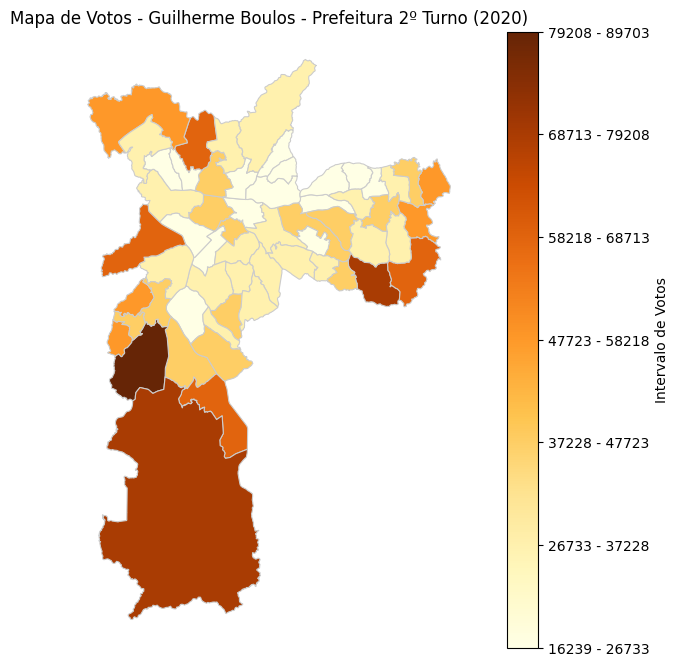

In [29]:
num_categorias = 7

intervalos_proporcionais = np.linspace(mapa_saopaulo_20_Boulos_2['QT_VOTOS'].min(), mapa_saopaulo_20_Boulos_2['QT_VOTOS'].max(), num_categorias + 1)

mapa_saopaulo_20_Boulos_2['categorias'] = pd.cut(mapa_saopaulo_20_Boulos_2['QT_VOTOS'], bins=intervalos_proporcionais, labels=False, include_lowest=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

cmap = plt.cm.YlOrBr

mapa_saopaulo_20_Boulos_2.plot(column="categorias", cmap=cmap, linewidth=0.8, ax=ax, edgecolor="0.8", legend=False, vmin=0)

ax.set_title("Mapa de Votos - Guilherme Boulos - Prefeitura 2º Turno (2020)")
ax.set_axis_off()

etiquetas_legenda = [f'{int(intervalos_proporcionais[i])} - {int(intervalos_proporcionais[i+1])}' for i in range(len(intervalos_proporcionais)-1)]

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=num_categorias-1))
sm._A = []
cbar = fig.colorbar(sm, ticks=np.arange(num_categorias), ax=ax)
cbar.set_label('Intervalo de Votos')
cbar.set_ticklabels(etiquetas_legenda)

mapa_saopaulo_20_Boulos_2.to_file('Mapas/São Paulo/2020/Mapa_Boulos_2020_2/Shapefile/mapa_votos_guilherme_boulos_2020_2.shp')

gdf_mapa = gpd.GeoDataFrame(mapa_saopaulo_20_Boulos_2)

caminho_geojson = "Mapas/São Paulo/2020/Mapa_Boulos_2020_2/Geojson/mapa_votos_guilherme_boulos_2020_2.geojson"

gdf_mapa.to_file(caminho_geojson, driver='GeoJSON')

plt.show()


## Criação do Mapa das Eleições de 2022

In [32]:
df_mun_SP_22_d = df_mun_SP_22[(df_mun_SP_22['DS_CARGO'] == 'DEPUTADO FEDERAL') & 
                            (df_mun_SP_22['NR_TURNO'] == 1) & 
                            (df_mun_SP_22['SG_UF'] == 'SP') & 
                            (df_mun_SP_22['NM_MUNICIPIO'] == 'SÃO PAULO') & 
                            (df_mun_SP_22['NR_VOTAVEL'] == 5010)]

In [33]:
pivot_df_2022_SP_Boulos = df_mun_SP_22_d.pivot_table(
    index='NR_ZONA',
    values='QT_VOTOS',
    aggfunc='sum',  # Usando a string 'sum' para evitar o FutureWarning
    fill_value=0
).reset_index()

In [34]:
SP_2020_Zonas.rename(columns={'ZEFINAL': 'NR_ZONA'}, inplace=True)

In [35]:
mapa_saopaulo_22_Boulos = SP_2020_Zonas.merge(pivot_df_2022_SP_Boulos, on='NR_ZONA')

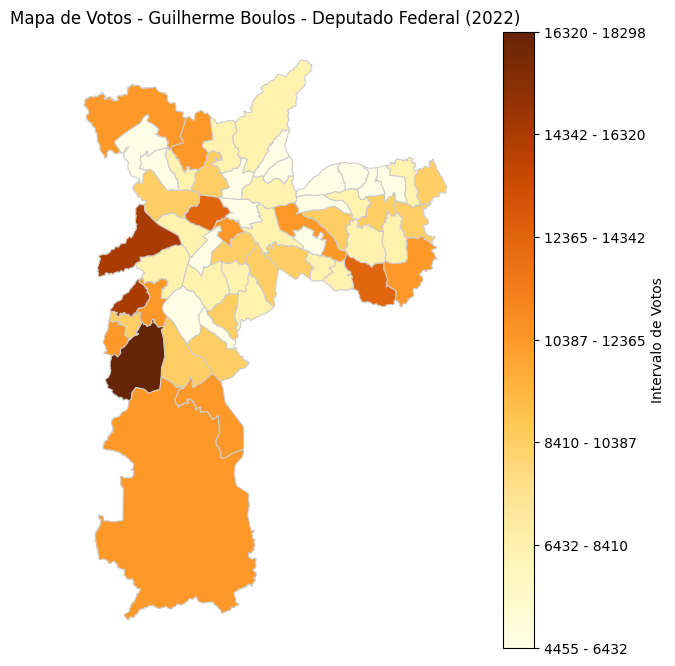

In [37]:
num_categorias = 7

intervalos_proporcionais = np.linspace(mapa_saopaulo_22_Boulos['QT_VOTOS'].min(), mapa_saopaulo_22_Boulos['QT_VOTOS'].max(), num_categorias + 1)

mapa_saopaulo_22_Boulos['categorias'] = pd.cut(mapa_saopaulo_22_Boulos['QT_VOTOS'], bins=intervalos_proporcionais, labels=False, include_lowest=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

cmap = plt.cm.YlOrBr

mapa_saopaulo_22_Boulos.plot(column="categorias", cmap=cmap, linewidth=0.8, ax=ax, edgecolor="0.8", legend=False, vmin=0)

ax.set_title("Mapa de Votos - Guilherme Boulos - Deputado Federal (2022)")
ax.set_axis_off()

etiquetas_legenda = [f'{int(intervalos_proporcionais[i])} - {int(intervalos_proporcionais[i+1])}' for i in range(len(intervalos_proporcionais)-1)]

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=num_categorias-1))
sm._A = []
cbar = fig.colorbar(sm, ticks=np.arange(num_categorias), ax=ax)
cbar.set_label('Intervalo de Votos')
cbar.set_ticklabels(etiquetas_legenda)

caminho_shapefile = "Mapas/São Paulo/2022/Mapa_Boulos_2022/Shapefile/mapa_votos_guilherme_boulos_2022.shp"

gdf_mapa = gpd.GeoDataFrame(mapa_saopaulo_22_Boulos)

gdf_mapa.to_file(caminho_shapefile)

caminho_geojson = "Mapas/São Paulo/2022/Mapa_Boulos_2022/Geojson/mapa_votos_guilherme_boulos_2022.geojson"

gdf_mapa.to_file(caminho_geojson, driver='GeoJSON')

plt.show()
